In [1]:
import pandas as pd
import os
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")

%matplotlib inline

In [2]:
#ifls5
cd = "C:/Users/Redata/Downloads/read/kemiskinan/hh14/"
a = pd.read_stata(cd + "b3a_cov.dta")
b = pd.read_stata(cd + "b3a_tk1.dta")
c = pd.read_stata(cd + "b3a_tk2.dta")
d = pd.read_stata(cd + "b3a_dl1.dta")

a.set_index(["hhid14", "pid14"], inplace=True)
b.set_index(["hhid14", "pid14"], inplace=True)
c.set_index(["hhid14", "pid14"], inplace=True)
d.set_index(["hhid14", "pid14"], inplace=True)

z = pd.concat([a, b, c, d], axis=1)
# our interest just people in youth age (15-24 based on ILO standard) and not as Head of household or the spoise
z = z[(z["age"] < 25) & (z.rspndnt == "3:Other HH member")]

consum14 = pd.read_stata("pce_14.dta", index_col="hhid14")
kon = pd.DataFrame()
for i in consum14.columns:
    if i != "commid14":
        if i != "owners":
            consum14[i] = consum14[i].astype("float64")
            kon[i] = consum14[i]
kon.fillna(0)

#HH expenditure per capita
kon["nonfood"] = consum14[["xnonfood2", "xtransf2", "xarisan", "xnonfood3", 
                           "xtransf3", "xhouse", "xeducall", 
                           "inonfood"]].fillna(0).sum(axis=1) / kon["hhsize"] # we include transfer and own produce
kon["food"] = consum14[["xstaple","xvege","xdried",
                         "xmeat","xfish","xdairy","xspices","xsugar","xoil","xbeve",
                         "xaltb","xsnack","xfdout", "xfdtout"]].sum(axis=1) / kon["hhsize"]
kon["total"] = kon["food"] + kon["nonfood"]

mer = pd.merge(z, kon[["total", "hhsize", "provid", 
                       "kabid", "nonfood", "food", "pce"]], left_on="hhid14", right_index=True, how="left")
mer = mer[mer["food"] != 0]
mer.reset_index(inplace=True)

#convert to real expenditure use CPI
ihk = pd.read_csv("C:/Users/Redata/Downloads/cpi indonesia after modelling 2000 - 2016 (511 cities inflation).csv")
ihk14 = ihk[(ihk["year"] == 2014) & (ihk["jenis"] == "Umum")][["nmkab2014", "IHK", "kabid14"]]

mer = pd.merge(mer, ihk14, left_on="kabid", right_on="kabid14")

for i in ["total", "food", "nonfood", "pce"]:
    mer[i] = mer[i] / (mer["IHK"]/100)

mer["total"] = mer["total"].apply(lambda x: 10 if x == 0 else x)
#mer["total_zscore"] = (mer["total"] - mer["total"].mean())/mer["total"].std(ddof=0)
mer["link"] = mer["pidlink"].iloc[:, -1]
del mer["pidlink"]

In [3]:
data = mer[["hhid14", "pid14", "panel", "tk01","tk02", "tk03", "tk04", "tk01a", "tk01b", "tk01c", "tk01d", 
                         "tk25a9x", "age","marstat","sex", "link", "hhsize", "nonfood","food",
     "total", "kabid", "nmkab2014", "pce"]]

#our filter 
data = data[(data["total"].notnull()) & (data["nonfood"] > 100)]

In [4]:
#rural urban
rural = pd.read_stata(cd+"bk_sc1.dta")[["sc05", "hhid14", "sc21x"]]
data = pd.merge(data, rural, left_on="hhid14", right_on="hhid14", how="left") #updated data

In [5]:
#relation with HH head
hh = pd.read_stata(cd +"ptrack.dta")[["ar02b_14", "hhid14", "pid14", "hhid07", "pid07"]]

#responden education
educ11 = pd.read_stata(cd +"b3a_dl1.dta")[["hhid14", "pid14", "dl06", "dl05a", "dl07a", "dl30", "dl42"]] # generala
#nilai UN/EBTANAS
a = pd.read_stata(cd +"b3a_dl3.dta")[["hhid14", "pid14", "dl3type", 
                                  "dl16c2", "dl16db", "dl16dc", "dl16dd", "dl16e"]]
#educ history of respondent
b = pd.read_stata(cd +"b3a_dl2.dta")[["dl2type", "dl10", "hhid14", "pid14", "dl16j", "dl16ja"]]

#educ duration after graduate
c = pd.read_stata(cd +"b3a_dl4.dta")[["hhid14", "pid14", "dl4type", "dl11d", "dl11e", "dl11f"]]
educ = pd.merge(b, a, left_on=["hhid14", "pid14", "dl2type"], right_on=["hhid14", "pid14", "dl3type"])
educ = pd.merge(educ, c, left_on=["hhid14", "pid14", "dl2type"], right_on=["hhid14", "pid14", "dl4type"])
for i in ["dl2type", "dl10", "dl16ja", "dl16j"]:
    educ[i] = educ[i].astype("str").str.extract('(\d+)').fillna("0").astype("int")

#the distance (in minutes) to school
#convert to minutes
educ.dl16ja = educ.dl16ja.apply(lambda x:60 if x == 2 else x) #change the a hour measurment
educ["dl16j"] = educ["dl16j"] * educ["dl16ja"]
educ.reset_index(inplace=True)
#just lastest education attainment
edu = educ[["hhid14", "pid14", "index", "dl2type", "dl16j"]].groupby(["hhid14", "pid14"], as_index=False).max()
educ22 = pd.merge(edu, educ[["index", "dl10","dl16c2", "dl16e", "dl11d", "dl11e", "dl11f"]],  
                  left_on="index", right_on="index")

# subjective welfare
sw = pd.read_stata(cd +"b3a_sw.dta")[["pid14", "hhid14", "sw00", "sw01", "sw03b"]]

#subjective health condition
kk = pd.read_stata(cd +"b3b_kk1.dta")[["hhid14", "pid14", "kk01", "kk02a", "kk02c"]]

var = [hh, educ11, educ22, sw, kk]

#data updated
for i in var:
    data = pd.merge(data, i, left_on=["hhid14", "pid14"], right_on=["hhid14", "pid14"], how="left")

#make desil group based on expenditure
#data["desil"] =pd.qcut(data.total, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
    
data.sample(3)

,hhid14,pid14,panel,tk01,tk02,tk03,tk04,tk01a,tk01b,tk01c,...,dl16e,dl11d,dl11e,dl11f,sw00,sw01,sw03b,kk01,kk02a,kk02c
1351,0462000,8.0,3:New,1:Working/trying to get work/helping to earn i...,NaN,NaN,NaN,1:Yes,3:No,1:Yes,...,31.73,NaN,,2011,2:Very satisfied,4,1:Less adequate,2:Somewhat healthy,0.0,2:Somewhat better now
1591,1481543,2.0,3:New,4:Housekeeping,3:No,3:No,3:No,3:No,3:No,1:Yes,...,6.00,NaN,,2011,2:Very satisfied,4,2:Adequate,2:Somewhat healthy,0.0,2:Somewhat better now
3020,1551912,3.0,3:New,3:Attending school,3:No,3:No,3:No,3:No,1:Yes,3:No,...,NaN,6:Still School,,NaN,2:Very satisfied,5,3:More than adequate,1:Very healthy,0.0,3:About the same


# Made Delta 

In [6]:
#HH expenditure per capita
x = pd.read_stata("C:/Users/Redata/Downloads/read/kemiskinan/consump/pce07nom.dta")
x["nonfood07"] = x[["xnonfood2", "xtransf2", "xarisan", "xnonfood3", 
                    "xtransf3", "xhouse", "xeducall", 
                    "inonfood"]].fillna(0).sum(axis=1) / x["hhsize"] # we include transfer and own produce
x["food07"] = x[["xstaple","xvege","xdried",
                 "xmeat","xfish","xdairy","xspices","xsugar","xoil","xbeve",
                 "xaltb","xsnack","xfdout", "xfdtout"]].sum(axis=1) / x["hhsize"]
x["total07"] = x["food07"] + x["nonfood07"]
mer1 = x[["hhid07", "nonfood07", "food07", "total07", "kabid", "pce"]].rename(columns={"pce":"pce07"})
ihk07 = ihk[(ihk["year"] == 2007) & (ihk["jenis"] == "Umum")][["nmkab2014", "IHK", "kabid07"]]
mer1 = pd.merge(mer1, ihk07, left_on="kabid", right_on="kabid07")

#adjust nominal to real values (in 2011 base year)
for i in ["total07", "food07", "nonfood07", "pce07"]:
    mer1[i] = mer1[i] / (mer1["IHK"]/100)
#mer1["desil07"] =pd.qcut(mer1.total07, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
#mer1["total_zscore07"] = (mer1["total07"] - mer1["total07"].mean())/mer1["total07"].std(ddof=0)
mer1

,hhid07,nonfood07,food07,total07,kabid,pce07,nmkab2014,IHK,kabid07
0,0012200,2.096299e+05,4.099275e+05,6.195574e+05,1201,5.043943e+05,NIAS,75.12,1201.0
1,0012200,2.096299e+05,4.099275e+05,6.195574e+05,1201,5.043943e+05,NIAS BARAT,75.12,1201.0
2,0012200,2.096299e+05,4.099275e+05,6.195574e+05,1201,5.043943e+05,GUNUNGSITOLI,75.12,1201.0
3,0012200,2.096299e+05,4.099275e+05,6.195574e+05,1201,5.043943e+05,NIAS UTARA,75.12,1201.0
4,0012241,2.018238e+05,4.439475e+05,6.457712e+05,1201,5.792110e+05,NIAS,75.12,1201.0
...,...,...,...,...,...,...,...,...,...
13938,3182000,4.532578e+05,4.896653e+05,9.429231e+05,7318,NaN,TORAJA UTARA,74.13,7318.0
13939,3210741,1.015221e+06,1.337178e+06,2.352399e+06,7318,2.352399e+06,TANA TORAJA,74.13,7318.0
13940,3210741,1.015221e+06,1.337178e+06,2.352399e+06,7318,2.352399e+06,TORAJA UTARA,74.13,7318.0
13941,3211131,6.494383e+05,6.672320e+05,1.316670e+06,7373,1.039165e+06,PALOPO,74.13,7373.0


In [7]:
#merge expenditure 2014 with 2007 in order to get the changing
jadi = pd.merge(data, mer1[["hhid07", "nonfood07", "food07", "total07", "pce07"]], left_on="hhid07", right_on="hhid07", how="left").drop_duplicates()

#our filter
jadi = jadi[(jadi["total07"].notnull()) & (jadi["nonfood07"] > 100)]

In [8]:
jadi["change"] = jadi["total"] - jadi["total07"]
jadi.to_stata("base_ifls2014.dta")
jadi

,hhid14,pid14,panel,tk01,tk02,tk03,tk04,tk01a,tk01b,tk01c,...,sw01,sw03b,kk01,kk02a,kk02c,nonfood07,food07,total07,pce07,change
1,0012241,3.0,3:New,3:Attending school,1:Yes,NaN,NaN,1:Yes,1:Yes,3:No,...,3,1:Less adequate,3:Somewhat unhealthy,2.0,1:Much better now,2.018238e+05,4.439475e+05,6.457712e+05,5.792110e+05,2.560688e+04
9,0012900,8.0,3:New,3:Attending school,1:Yes,NaN,NaN,3:No,1:Yes,1:Yes,...,2,2:Adequate,3:Somewhat unhealthy,0.0,1:Much better now,5.724175e+04,3.452888e+05,4.025306e+05,4.025306e+05,5.699370e+05
13,0020100,11.0,3:New,3:Attending school,3:No,3:No,1:Yes,3:No,1:Yes,3:No,...,3,2:Adequate,3:Somewhat unhealthy,3.0,3:About the same,5.900001e+05,5.909257e+05,1.180926e+06,1.085888e+06,-4.458962e+05
14,0020400,7.0,3:New,3:Attending school,1:Yes,NaN,NaN,1:Yes,1:Yes,3:No,...,2,3:More than adequate,1:Very healthy,1.0,2:Somewhat better now,6.433740e+04,2.508569e+05,3.151943e+05,3.079399e+05,-7.553332e+04
15,0020600,7.0,3:New,3:Attending school,1:Yes,NaN,NaN,1:Yes,1:Yes,3:No,...,3,1:Less adequate,4:Very unhealthy,0.0,2:Somewhat better now,9.616182e+04,3.630824e+05,4.592442e+05,4.211587e+05,3.406324e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6080,3191531,4.0,3:New,4:Housekeeping,3:No,3:No,3:No,3:No,3:No,1:Yes,...,4,2:Adequate,2:Somewhat healthy,0.0,3:About the same,1.742020e+06,3.063266e+05,2.048347e+06,1.424288e+06,-1.199306e+06
6081,3191700,12.0,3:New,3:Attending school,1:Yes,NaN,NaN,1:Yes,1:Yes,3:No,...,2,2:Adequate,2:Somewhat healthy,1.0,2:Somewhat better now,6.010867e+05,1.158167e+06,1.759253e+06,1.759253e+06,-8.233198e+05
6082,3194100,6.0,3:New,1:Working/trying to get work/helping to earn i...,NaN,NaN,NaN,1:Yes,3:No,3:No,...,2,2:Adequate,1:Very healthy,0.0,1:Much better now,1.075975e+05,1.233388e+05,2.309363e+05,2.309363e+05,3.719049e+05
6084,3201851,3.0,3:New,3:Attending school,3:No,3:No,3:No,3:No,1:Yes,3:No,...,4,2:Adequate,1:Very healthy,0.0,2:Somewhat better now,2.586261e+05,2.923908e+05,5.510169e+05,5.459129e+05,8.223435e+05


Text(0.5, 1.0, 'Missing Values Map in Our Data')

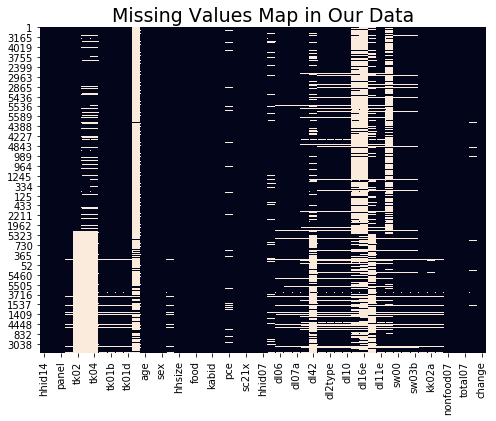

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(jadi.isnull().sort_values("tk02"), cbar=False)
plt.title("Missing Values Map in Our Data", size=19)